In [433]:
%reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

train1 = pd.read_csv('train_dataset01.csv')
train2 = pd.read_csv('train_dataset02.csv')
test = pd.read_csv('test_dataset.csv')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [434]:
# Function to create new features
def create_new_features(data, fluc_window, MA_window):
    """
    Fluctions refer to the sum of differences
    between each row and its previous row in a window
    """
    numerics = data.select_dtypes(include="float64")
    booleans = data.select_dtypes(include="bool")
    
    # Calculate fluctuations
    flucs = numerics.diff()
    flucs = flucs.abs()
    flucs = flucs.rolling(fluc_window).sum()
    flucs = flucs.fillna(0)
    flucs.columns = [str(col) + '_delta_t' for col in flucs.columns]
    
    # Calculate Moving Average
    ma = numerics.rolling(MA_window).mean()
    ma = ma.fillna(numerics.mean())
    ma.columns = [str(col) + '_MA' for col in ma.columns]
    
    # Create output
    out = pd.concat([data.reset_index(drop=True), flucs], axis=1)
    out = pd.concat([out.reset_index(drop=True), ma], axis=1)

    return out


In [435]:
# Function to standardize features
def standardise(data, means, stds):
    """
    Standardise every numeric column based on given
    means and stds
    """
    numeric_cols = data.select_dtypes(include="float64").columns
    data[numeric_cols] = (data[numeric_cols] - means)/stds


In [436]:
# Function to build one tree for each feature
def create_trees(data):
    """
    For each feature, build a tree to detect anomalies
    """
    trees = {}
    for col in data.columns:
        if str(col) not in ["ATT_FLAG", "DATETIME"]:
            clf = DecisionTreeClassifier(max_depth=1)
            clf = clf.fit(data[[col]], data["ATT_FLAG"])
            trees[col] = clf

    return trees
    

In [437]:
# Function to vote anomalies from tree results
def create_votes(data, trees):
    """
    For each column, use decision tree to decide whether 
    it is an anomaly. Votes are then summed up into a votes column
    """
    # Predict
    votes = pd.DataFrame()
    for col in data.columns:
        if str(col) in trees:
            try:
                votes[col] = trees[col].predict(data[[col]])
            except Exception:
                continue
            
    # Sum
    data["votes"] = votes.sum(axis=1)


In [438]:
# Function to get scores from votes
def create_scores(data, alpha):
    """
    Create score from votes
    Each score depends on all previous scores
    """
    scores = []
    for i in range(len(data["votes"])):
        if i > 1:
            score = alpha*scores[i-1] + data["votes"][i]
        else:
            score = data["votes"][i]
        scores.append(score)
    return scores


In [439]:
# Function to change scores to ATT_FLAG
def create_ATT_FLAG(data, scores, min_votes):
    """
    Create dataframe in submission format
    """
    temp = np.asarray(scores)

    out = data[["DATETIME"]].copy()
    out["ATT_FLAG"] = np.where(temp >= min_votes, 1, 0)

    return out


In [440]:
def frange(x, y, jump):
    """
    range for floats
    """
    while x < y:
        yield x
        x += jump


In [441]:
# Drop continuous columns that do not want to use in trees
ignore = ["LEVEL_T5", "FLOW_PU3", "FLOW_PU5", "FLOW_PU9"]
train2 = train2.drop(ignore, axis=1)

# Create new features
train2 = create_new_features(train2, 10, 10)
test = create_new_features(test, 10, 10)

# Learn mean and std from no attack data
no_attacks = train2[~train2.ATT_FLAG]
means = no_attacks.select_dtypes(include="float64").mean()
stds = no_attacks.select_dtypes(include="float64").std()

# Standardize
standardise(train2, means, stds)
standardise(test, means, stds)

# Build trees
trees = create_trees(train2)

# Create votes
create_votes(train2, trees)
create_votes(test, trees)

In [442]:
# Grid Search for best decay rate and min_vote
bestF1 = 0
bestAlpha = 0
bestMinVotes = 0
y_true = train2.ATT_FLAG

for alpha in frange(0.5, 0.99, 0.01):
    train2_scores = create_scores(train2, alpha)

    for min_votes in range(1, 100):            
        train2_out = create_ATT_FLAG(train2, train2_scores, min_votes)

        # Calculate F score in train2
        y_pred = train2_out.ATT_FLAG == 1
        f1 = f1_score(y_true, y_pred)

        if f1 > bestF1:
            bestF1 = f1
            bestAlpha = alpha
            bestMinVotes = min_votes
                
print(bestF1, bestAlpha, bestMinVotes)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.8194736842105264 0.5 4


In [463]:
test_scores = create_scores(test, 0.972)

In [466]:
test_out = create_ATT_FLAG(test, test_scores, 110)

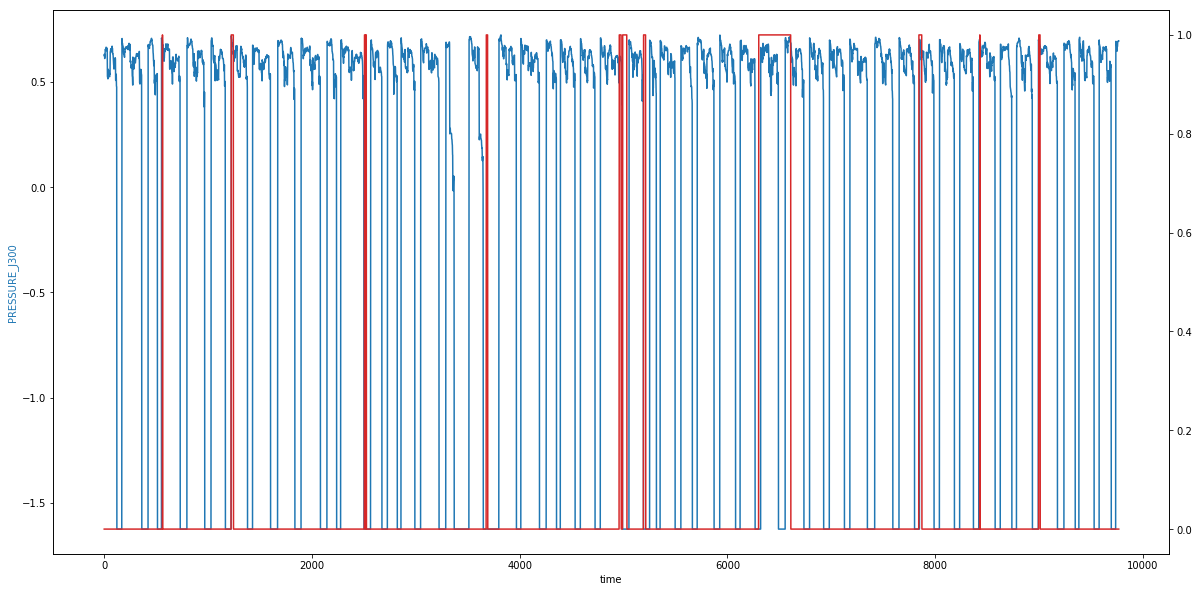

In [467]:
# Plot
fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('time')
ax1.set_ylabel('PRESSURE_J300', color=color)
ax1.plot(test['PRESSURE_J300'], color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.plot(test_out['ATT_FLAG'], color=color)

plt.show()

In [446]:
test_out["ATT_FLAG"] = test_out["ATT_FLAG"].astype('bool')
test_out.head()

,DATETIME,ATT_FLAG
0,2016-09-18 04:45:00,False
1,2016-09-18 05:00:00,False
2,2016-09-18 05:15:00,False
3,2016-09-18 05:30:00,False
4,2016-09-18 05:45:00,False


In [447]:
# test_out.to_csv("output3.csv", index=False)